<a href="https://colab.research.google.com/github/seohyun34/test/blob/main/chapter05_fundamentals-of-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Fundamentals of machine learning

## Generalization: The goal of machine learning

### Underfitting and overfitting

#### Noisy training data

#### Ambiguous features

#### Rare features and spurious correlations

**Adding white-noise channels or all-zeros channels to MNIST**:  MNIST 숫자 이미지 분류 문제를 딥러닝으로 해결하면서, 불필요한 정보가 들어오면 모델이 어떻게 반응하는지를 실험하는 코드

두 가지 경우를 비교:

1. 정상 이미지 데이터 + 랜덤한 "잡음 채널" 추가

2. 정상 이미지 데이터 + 전부 0인 "쓸모 없는 채널" 추가

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28)) #이미지를 평평하게(1차원으로) 만듦
train_images = train_images.astype("float32") / 255   # 정규화

# 잡음 추가
train_images_with_noise_channels = np.concatenate( #원래 이미지(784개 숫자) 옆에 랜덤한 숫자 784개 추가
    [train_images, np.random.random((len(train_images), 784))], axis=1) #한 이미지가 784+784=1568개의 숫자로 표현됨

train_images_with_zeros_channels = np.concatenate( #전부 0인 숫자 784개 추가
    [train_images, np.zeros((len(train_images), 784))], axis=1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Training the same model on MNIST data with noise channels or all-zero channels**: 모델 정의

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2) #20% 데이터를 검증용으로 따로 떼둠

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6946 - loss: 1.0649 - val_accuracy: 0.8975 - val_loss: 0.3291
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9100 - loss: 0.2935 - val_accuracy: 0.9312 - val_loss: 0.2209
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9421 - loss: 0.1874 - val_accuracy: 0.9487 - val_loss: 0.1738
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9595 - loss: 0.1313 - val_accuracy: 0.9488 - val_loss: 0.1788
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9703 - loss: 0.0967 - val_accuracy: 0.9638 - val_loss: 0.1212
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9793 - loss: 0.0653 - val_accuracy: 0.9614 - val_loss: 0.1303
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9838 - loss: 0.0511 - val_accuracy: 0.9617 - val_loss: 0.1340
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9884 - loss: 0.0373 - val_accuracy: 0.

**Plotting a validation accuracy comparison** 검증 정확도 시각화

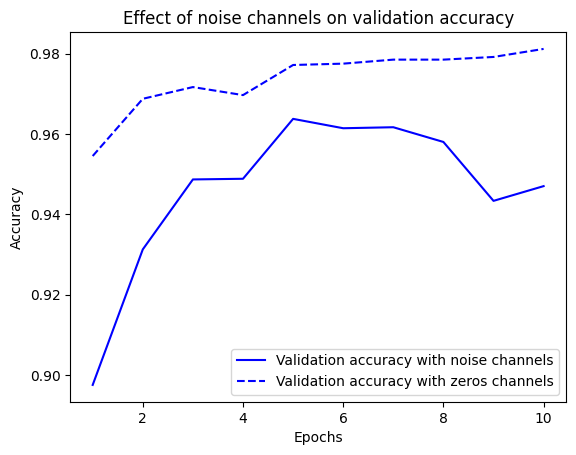

In [ ]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# 해석: 잡음 채널O - 정확도가 더 낮고 불안정 / 0 채널- 정확도가 더 높고 안정적
#-> 딥러닝 모델이 잡음같은 쓸모없는 정보에 영향 받을 수 있음

### The nature of generalization in deep learning

**Fitting a MNIST model with randomly shuffled labels**: 레이블(정답)을 무작위로 섞었을 때도 학습할 수 있는지 실험

In [ ]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels) # 레이블 섞음

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)
# 결과- accuracy: 점점 올라감/ val_accuracy: 10% 근처에서 계속 정체 (랜덤 예측과 같음)/ val_loss: 계속 증가

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1049 - loss: 2.3341 - val_accuracy: 0.1014 - val_loss: 2.3072
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1165 - loss: 2.2987 - val_accuracy: 0.1037 - val_loss: 2.3082
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1286 - loss: 2.2895 - val_accuracy: 0.1068 - val_loss: 2.3182
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1406 - loss: 2.2774 - val_accuracy: 0.1042 - val_loss: 2.3252
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1600 - loss: 2.2578 - val_accuracy: 0.1058 - val_loss: 2.3374
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1690 - loss: 2.2385 - val_accuracy: 0.0998 - val_loss: 2.3497
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1860 - loss: 2.2131 - val_accuracy: 0.1055 - val_loss: 2.3645
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2022 - loss: 2.1848 - val_accu

💡 실험이 말하는 것
1. 신경망은 무작위 데이터도 외울 수 있다:
학습 정확도(accuracy)가 0.7 이상까지 증가한 것은 모델이 훈련 데이터의 패턴을 학습한 것처럼 보이지만, 사실은 단순히 훈련 샘플 하나하나를 외운 것입니다.

즉, 입력 이미지와 아무 상관없는 정답을 맞추는 법을 '외워서' 잘 예측하고 있는 것뿐이에요.

2. 하지만 일반화는 전혀 안 된다:
검증 데이터는 새로운 데이터이므로, 외운 정답이 통하지 않습니다.

검증 정확도가 10% 수준인 이유는 10개의 클래스를 무작위로 찍었을 때의 기대값이기 때문입니다.

3. 손실 값(loss)이 증가하는 이유:
모델은 점점 훈련 데이터에 과적합(overfitting)되고 있고, 이로 인해 검증 데이터에 대해서는 예측이 더 엉망이 되기 때문입니다.

softmax 결과가 점점 더 확신(confident) 있게 나오지만, 틀린 답을 확신하게 되면서 loss가 커져요.



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


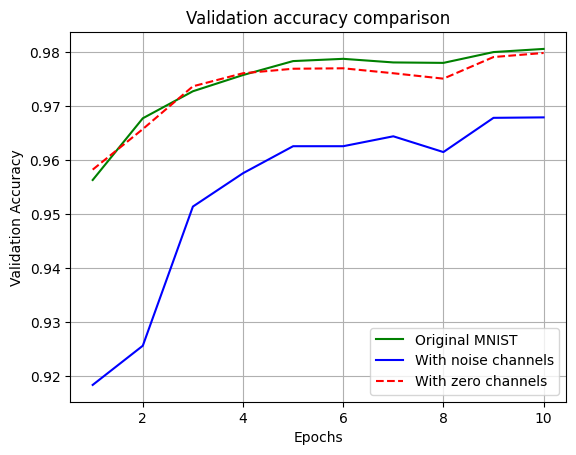

In [1]:
# - From Training the same model on MNIST data with noise channels or all-zero channels  Add validation accuracy of original data for mnist data. (원본 MNIST 데이터만으로 학습한 경우의 성능과 노이즈 채널 /0으로 채운 채널 추가한 경우의 모델 성능을 비교)
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# 공통 모델 생성 함수
def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# 1. 데이터 불러오기
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28)).astype("float32") / 255

# 2. 잡음 채널 / 0 채널 추가
noise_channels = np.random.random((len(train_images), 784))     # 랜덤 채널
zero_channels = np.zeros((len(train_images), 784))              # 0 채널

train_images_noise = np.concatenate([train_images, noise_channels], axis=1)
train_images_zeros = np.concatenate([train_images, zero_channels], axis=1)

# 3. 원본 학습
model = get_model()
history_original = model.fit(
    train_images, train_labels,
    epochs=10, batch_size=128,
    validation_split=0.2,
    verbose=0)

# 4. 노이즈 채널 학습
model = get_model()
history_noise = model.fit(
    train_images_noise, train_labels,
    epochs=10, batch_size=128,
    validation_split=0.2,
    verbose=0)

# 5. 제로 채널 학습
model = get_model()
history_zeros = model.fit(
    train_images_zeros, train_labels,
    epochs=10, batch_size=128,
    validation_split=0.2,
    verbose=0)

# 6. 결과 시각화
epochs = range(1, 11)
plt.plot(epochs, history_original.history['val_accuracy'], 'g-', label='Original MNIST')
plt.plot(epochs, history_noise.history['val_accuracy'], 'b-', label='With noise channels')
plt.plot(epochs, history_zeros.history['val_accuracy'], 'r--', label='With zero channels')
plt.title("Validation accuracy comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()
# 원본 MNIST (784차원): 정상적인 데이터
# 노이즈 채널 추가 (784+784=1568차원): 무작위 숫자들이 모델의 일반화 성능을 방해할 수 있음
# 0 채널 추가: 정보가 없는 값이기 때문에 영향이 거의 없을 수도 있음

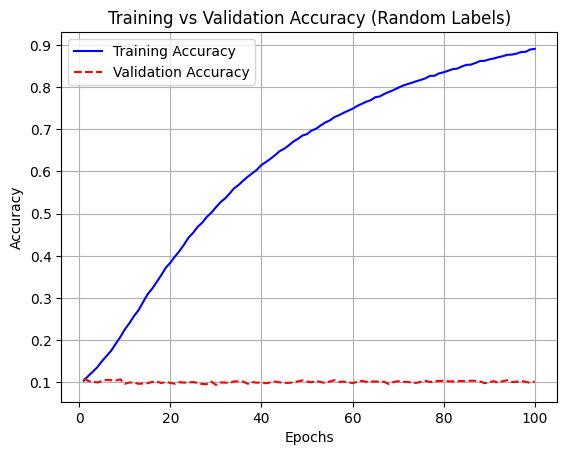

In [2]:
# - Fitting a MNIST model with randomly shuffled labels.  Visualize training accuracy and validation accuracy? (랜덤 레이블 학습 후 훈련 정확도와 검증 정확도 시각화)
# 데이터 준비
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28)).astype("float32") / 255

# 라벨 무작위 섞기
random_train_labels = train_labels.copy()
np.random.shuffle(random_train_labels)

# 모델 정의 및 학습
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_random_labels = model.fit(
    train_images, random_train_labels,
    epochs=100, batch_size=128,
    validation_split=0.2,
    verbose=0
)

# 정확도 시각화
epochs = range(1, 101)
plt.plot(epochs, history_random_labels.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history_random_labels.history['val_accuracy'], 'r--', label='Validation Accuracy')
plt.title("Training vs Validation Accuracy (Random Labels)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()
# training accuracy는 점점 올라가지만, val accuracy는 무작위이기 때문에 올라가지X → 일반화 능력 없음. 모델은 단순히 데이터를 외워서 학습함→ 과적합

#### The manifold hypothesis

#### Interpolation as a source of generalization

#### Why deep learning works

#### Training data is paramount

## Evaluating machine-learning models

### Training, validation, and test sets

#### Simple hold-out validation

#### K-fold validation

#### Iterated K-fold validation with shuffling

### Beating a common-sense baseline

### Things to keep in mind about model evaluation

## Improving model fit

### Tuning key gradient descent parameters

**학습률이 너무 클 때/적절**할 때 결과가 어떻게 다른지 두 개의 모델로 비교

**Training a MNIST model with an incorrectly high learning rate**

In [ ]:
(train_images, train_labels), _ = mnist.load_data() #_: 테스트셋은 지금 사용하지 않으므로 무시
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.), # 학습률이 너무 큰 1.0을 사용
              loss="sparse_categorical_crossentropy", # 정답이 0~9 정수인 경우 사용하는 손실 함수
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)
#첫 번째 에폭에서 loss가 3000 이상! 비정상적인 수치 > 학습률이 너무 커서 모델이 발산
# accuracy와 val_accuracy 매우 낮음

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4241 - loss: 3002.3223 - val_accuracy: 0.1806 - val_loss: 2.3605
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1612 - loss: 2.6075 - val_accuracy: 0.1648 - val_loss: 2.2693
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1456 - loss: 2.5069 - val_accuracy: 0.1489 - val_loss: 2.2874
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1370 - loss: 2.4229 - val_accuracy: 0.1392 - val_loss: 2.3388
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1460 - loss: 2.5348 - val_accuracy: 0.1653 - val_loss: 2.4115
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1438 - loss: 2.3922 - val_accuracy: 0.1700 - val_loss: 2.2778
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1536 - loss: 2.5666 - val_accuracy: 0.1330 - val_loss: 2.4046
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1656 - loss: 2.3993 - val_accuracy:

**The same model with a more appropriate learning rate**

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2), # 1e-2: 학습률 적절히 작아짐
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)
# 정확도가 매우 높고 안정적
#val_loss은 에폭 2 이후부터는 다소 증가→ 과적합 가능성도 살짝 보임

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8329 - loss: 0.9460 - val_accuracy: 0.9618 - val_loss: 0.1433
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9648 - loss: 0.1259 - val_accuracy: 0.9688 - val_loss: 0.1192
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9747 - loss: 0.0942 - val_accuracy: 0.9666 - val_loss: 0.1520
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9799 - loss: 0.0803 - val_accuracy: 0.9665 - val_loss: 0.1729
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9834 - loss: 0.0662 - val_accuracy: 0.9690 - val_loss: 0.1646
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9856 - loss: 0.0562 - val_accuracy: 0.9588 - val_loss: 0.2539
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9872 - loss: 0.0543 - val_accuracy: 0.9693 - val_loss: 0.2031
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9877 - loss: 0.0502 - val_accuracy: 0.

### Leveraging better architecture priors

### Increasing model capacity
: 딥러닝 모델의 구조(모델 용량= capacity)가 성능에 어떤 영향을 주는지 비교하는 실험

**A simple logistic regression on MNIST**

In [ ]:
model = keras.Sequential([layers.Dense(10, activation="softmax")]) # 출력층 하나만 있는 모델
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)
# 괜찮은 성능이지만, 모델이 단순해서 성능 향상이 점점 둔화-> capacity가 부족함

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7299 - loss: 1.0542 - val_accuracy: 0.8984 - val_loss: 0.3648
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8996 - loss: 0.3670 - val_accuracy: 0.9134 - val_loss: 0.3108
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9098 - loss: 0.3243 - val_accuracy: 0.9183 - val_loss: 0.2941
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9158 - loss: 0.3058 - val_accuracy: 0.9203 - val_loss: 0.2840
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9170 - loss: 0.2947 - val_accuracy: 0.9240 - val_loss: 0.2784
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9188 - loss: 0.2851 - val_accuracy: 0.9242 - val_loss: 0.2746
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9234 - loss: 0.2821 - val_accuracy: 0.9260 - val_loss: 0.2716
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9238 - loss: 0.2736 - val_accuracy: 0.

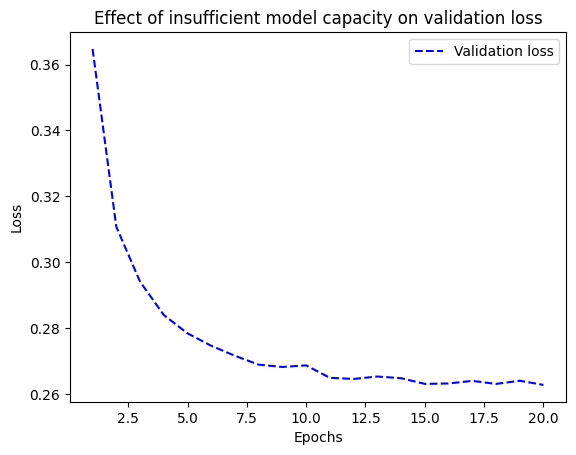

In [ ]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"] # 각 에폭마다의 val_loss 기록 가져옴
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# 결과: 학습하면서 손실이 줄어들다가 성능이 정체됨. 복잡한 패턴을 잘 못 잡는다는 뜻

In [ ]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax")]) # 큰 모델: 두 개의 은닉층 포함
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)
#Epoch 1: train acc 81.93%, val acc 94.56% → 첫 에폭부터 높은 검증 정확도.
# Epoch 10 이후부터: accuracy 거의 99.8%까지 올라감. 그러나 검증 성능은 정체 또는 하락 → val_loss 증가!
# → 과적합이 시작되었음을 의미→ 모델이 너무 복잡해서 훈련 데이터에 과하게 맞춰짐.

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8193 - loss: 0.6395 - val_accuracy: 0.9456 - val_loss: 0.1906
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9468 - loss: 0.1787 - val_accuracy: 0.9521 - val_loss: 0.1580
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9644 - loss: 0.1209 - val_accuracy: 0.9662 - val_loss: 0.1147
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9734 - loss: 0.0893 - val_accuracy: 0.9678 - val_loss: 0.1069
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9797 - loss: 0.0684 - val_accuracy: 0.9687 - val_loss: 0.1076
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9829 - loss: 0.0571 - val_accuracy: 0.9721 - val_loss: 0.0936
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9847 - loss: 0.0483 - val_accuracy: 0.9711 - val_loss: 0.0998
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9885 - loss: 0.0372 - val_accuracy: 0.

## Improving generalization

### Dataset curation

### Feature engineering

### Using early stopping

### Regularizing your model

#### Reducing the network's size

🔍 특징 요약

기본 모델: validation accuracy가 5-6 epoch 이후 감소하기 시작했어요 → 과적합이 시작된 시점.

축소된 모델: validation 성능이 더 오래 유지됨 → 모델 용량 축소는 과적합 완화에 도움됨.

확장된 모델: 학습 데이터에 너무 잘 맞아버려서 validation 성능이 빠르게 떨어져요 → 심한 과적합.

**Original model**

In [6]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)
#(train_data, train_labels), (test_data, test_labels) < 원래 이렇게 쓰는데 test_data 안씀

def vectorize_sequences(sequences, dimension=10000): #데이터 벡터화 (정수 리스트→ 벡터)
    results = np.zeros((len(sequences), dimension))  #원핫인코딩
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.     # 리스트 안의 정수들을 해당 위치에 1로 설정
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid") #이진 분류에서 자주 사용
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)
# validation accuracy가 5-6 epoch 이후 감소하기 시작 → 과적합이 시작된 시점.

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.6864 - loss: 0.6092 - val_accuracy: 0.8719 - val_loss: 0.4004
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8875 - loss: 0.3514 - val_accuracy: 0.8702 - val_loss: 0.3384
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9285 - loss: 0.2504 - val_accuracy: 0.8916 - val_loss: 0.2839
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9395 - loss: 0.1985 - val_accuracy: 0.8890 - val_loss: 0.2772
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9488 - loss: 0.1649 - val_accuracy: 0.8868 - val_loss: 0.2813
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9601 - loss: 0.1374 - val_accuracy: 0.8846 - val_loss: 0.2885
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9658 - loss: 0.1177 - val_accuracy: 0.8849 - val_loss: 0.2985
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accurac

**Version of the model with lower capacity**: validation 성능이 더 오래 유지됨 → 모델 용량 축소는 과적합 완화에 도움됨.

In [ ]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"), # 뉴런 수 줄임
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6895 - loss: 0.6196 - val_accuracy: 0.8519 - val_loss: 0.4758
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8813 - loss: 0.4237 - val_accuracy: 0.8677 - val_loss: 0.3857
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9091 - loss: 0.3310 - val_accuracy: 0.8836 - val_loss: 0.3344
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9238 - loss: 0.2731 - val_accuracy: 0.8882 - val_loss: 0.3062
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9325 - loss: 0.2330 - val_accuracy: 0.8857 - val_loss: 0.2944
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9380 - loss: 0.2010 - val_accuracy: 0.8920 - val_loss: 0.2797
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9508 - loss: 0.1774 - val_accuracy: 0.8859 - val_loss: 0.2824
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9531 - loss: 0.1614 - val_accuracy: 0.8918 - 

**Version of the model with higher capacity**

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"), #뉴런 개많아짐
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.6652 - loss: 0.6596 - val_accuracy: 0.8608 - val_loss: 0.3600
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8682 - loss: 0.3253 - val_accuracy: 0.8552 - val_loss: 0.3411
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8956 - loss: 0.2489 - val_accuracy: 0.8841 - val_loss: 0.2769
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9371 - loss: 0.1673 - val_accuracy: 0.8923 - val_loss: 0.2685
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9634 - loss: 0.1094 - val_accuracy: 0.8851 - val_loss: 0.2949
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9734 - loss: 0.0883 - val_accuracy: 0.8301 - val_loss: 0.5535
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9616 - loss: 0.0932 - val_accuracy: 0.8869 - val_loss: 0.3576
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9857 - loss: 0.0558 - val_accuracy: 0.8821 - 

#### Adding weight regularization

**Adding L2 weight regularization to the model**

In [ ]:
from tensorflow.keras import regularizers #regularizers: 가중치에 패널티를 부여하는 함수들이 들어있는 모듈
model = keras.Sequential([                #가중치가 너무 커지지 않도록 제약줌- overfitting 방지
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002), # L2 정규화. 0.002: 정규화 강도. 클수록 제약이 세짐
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid") # sigmoid: 0~1 사이의 값을 출력-> 긍정 리뷰일 확률 예측
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy", # 이진 분류
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

# 결과:
#Epoch 5: 정확도 93%, 손실 0.27 → 잘 학습되고 있음. 검증 정확도도 88% → 성능 좋음!
#Epoch 15~20- 정확도는 계속 높아지지만 val_loss는 오히려 증가→ 과적합 신호

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6767 - loss: 0.6987 - val_accuracy: 0.8211 - val_loss: 0.5129
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8830 - loss: 0.4387 - val_accuracy: 0.8653 - val_loss: 0.4182
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9137 - loss: 0.3443 - val_accuracy: 0.8772 - val_loss: 0.3810
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9321 - loss: 0.2948 - val_accuracy: 0.8791 - val_loss: 0.3725
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9330 - loss: 0.2750 - val_accuracy: 0.8854 - val_loss: 0.3572
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9412 - loss: 0.2550 - val_accuracy: 0.8658 - val_loss: 0.4044
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9442 - loss: 0.2457 - val_accuracy: 0.8792 - val_loss: 0.3739
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9505 - loss: 0.2340 - val_accuracy: 0.8830 - 

**Different weight regularizers available in Keras**

In [ ]:
from tensorflow.keras import regularizers
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

#### Adding dropout- 드롭아웃 적용한 모델

**Adding dropout to the IMDB model**

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5), #Dropout(0.5): 학습시 무작위로 절반의 뉴런을 꺼버림. 과적합 막고 일반화 성능↑
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5), # 학습할 때만 적용되고, 평가나 예측 시에는 꺼지지 X
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4) # 이부분은 위랑 동일

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.5734 - loss: 0.6683 - val_accuracy: 0.8337 - val_loss: 0.5272
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7406 - loss: 0.5364 - val_accuracy: 0.8411 - val_loss: 0.4333
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8123 - loss: 0.4460 - val_accuracy: 0.8818 - val_loss: 0.3359
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8472 - loss: 0.3803 - val_accuracy: 0.8869 - val_loss: 0.2972
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8883 - loss: 0.3139 - val_accuracy: 0.8917 - val_loss: 0.2775
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9052 - loss: 0.2679 - val_accuracy: 0.8728 - val_loss: 0.3079
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9201 - loss: 0.2381 - val_accuracy: 0.8904 - val_loss: 0.2810
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9273 - loss: 0.2104 - val_accuracy: 0.8912 - 

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3926 - loss: 3121.7185 - val_accuracy: 0.1677 - val_loss: 2.3948
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1796 - loss: 2.8266 - val_accuracy: 0.1527 - val_loss: 2.2741
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1631 - loss: 2.3392 - val_accuracy: 0.1931 - val_loss: 2.4062
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1598 - loss: 2.4239 - val_accuracy: 0.1906 - val_loss: 2.2433
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1808 - loss: 2.4648 - val_accuracy: 0.1821 - val_loss: 2.2620
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1764 - loss: 2.4435 - val_accuracy: 0.1884 - val_loss: 2.1945
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1782 - loss: 2.8268 - val_accuracy: 0.1232 - val_loss: 2.3934
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1550 - loss: 2.3907 - val_accuracy:

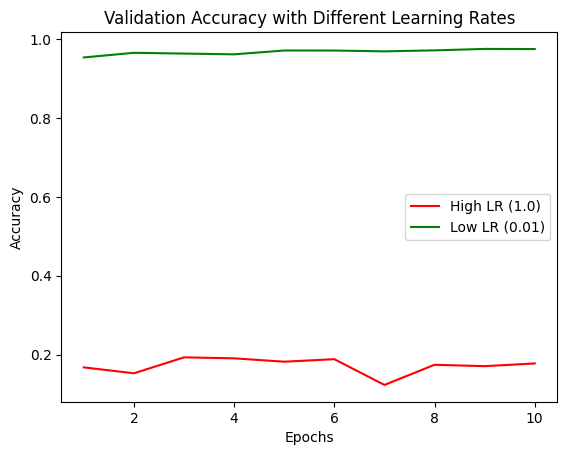

In [3]:
# - From Tuning key gradient descent parameters, Modify learning rates and check when model fails
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 데이터 전처리
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28)).astype("float32") / 255

# 모델 정의 함수
def get_model(learning_rate):
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# 학습률 1.0 모델
model_high_lr = get_model(1.0)
history_high_lr = model_high_lr.fit(
    train_images, train_labels,
    epochs=10, batch_size=128, validation_split=0.2)

# 학습률 0.01 모델
model_low_lr = get_model(0.01)
history_low_lr = model_low_lr.fit(
    train_images, train_labels,
    epochs=10, batch_size=128, validation_split=0.2)

# 결과 시각화
epochs = range(1, 11)
val_acc_high = history_high_lr.history["val_accuracy"]
val_acc_low = history_low_lr.history["val_accuracy"]

plt.plot(epochs, val_acc_high, "r-", label="High LR (1.0)")
plt.plot(epochs, val_acc_low, "g-", label="Low LR (0.01)")
plt.title("Validation Accuracy with Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7210 - loss: 1.0571 - val_accuracy: 0.9018 - val_loss: 0.3624
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8985 - loss: 0.3648 - val_accuracy: 0.9165 - val_loss: 0.3102
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9120 - loss: 0.3222 - val_accuracy: 0.9193 - val_loss: 0.2928
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9193 - loss: 0.2985 - val_accuracy: 0.9222 - val_loss: 0.2834
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9175 - loss: 0.2957 - val_accuracy: 0.9241 - val_loss: 0.2781
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9207 - loss: 0.2818 - val_accuracy: 0.9242 - val_loss: 0.2753
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9230 - loss: 0.2804 - val_accuracy: 0.9244 - val_loss: 0.2721
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9237 - loss: 0.2718 - val_accuracy: 0.

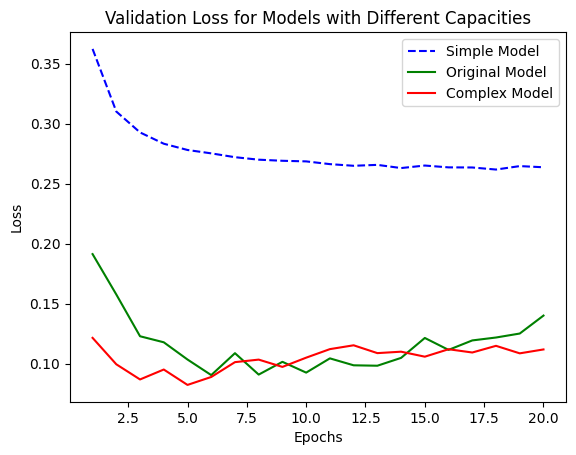

In [4]:
# - Visualize validation loss of the original model, model with lower capacity and model with larger capacity
# 세 가지 모델(간단한 모델, 원래 모델, 복잡한 모델)의 val loss 비교
# 간단한 모델
simple_model = keras.Sequential([layers.Dense(10, activation="softmax")])
simple_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_simple = simple_model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2)

# 원래 모델
original_model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax")
])
original_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_original = original_model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2)

# 복잡한 모델
complex_model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
complex_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_complex = complex_model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2)

# 결과 시각화
val_loss_simple = history_simple.history["val_loss"]
val_loss_original = history_original.history["val_loss"]
val_loss_complex = history_complex.history["val_loss"]

epochs = range(1, 21)
plt.plot(epochs, val_loss_simple, "b--", label="Simple Model")
plt.plot(epochs, val_loss_original, "g-", label="Original Model")
plt.plot(epochs, val_loss_complex, "r-", label="Complex Model")
plt.title("Validation Loss for Models with Different Capacities")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6936 - loss: 0.5970 - val_accuracy: 0.8495 - val_loss: 0.4057
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8928 - loss: 0.3380 - val_accuracy: 0.8854 - val_loss: 0.3073
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9199 - loss: 0.2436 - val_accuracy: 0.8773 - val_loss: 0.3080
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9370 - loss: 0.1942 - val_accuracy: 0.8905 - val_loss: 0.2746
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9534 - loss: 0.1541 - val_accuracy: 0.8828 - val_loss: 0.2912
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9603 - loss: 0.1318 - val_accuracy: 0.8805 - val_loss: 0.3047
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9643 - loss: 0.1163 - val_accuracy: 0.8831 - val_loss: 0.3036
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9719 - loss: 0.0999 - val_accuracy: 0.8696 - v

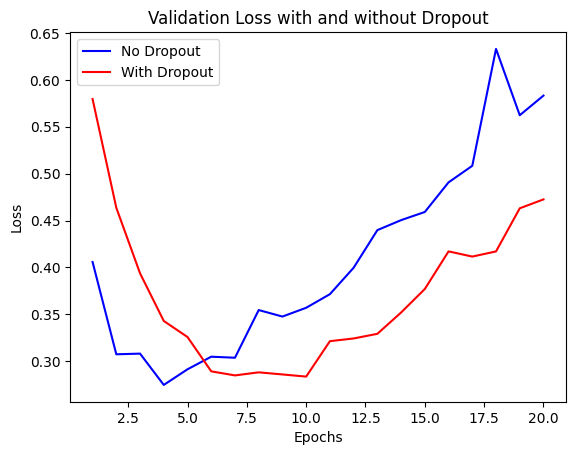

In [7]:
# - Visualize validation loss of the original model and model with dropout - 드롭아웃 없는 vs 있는
# 드롭아웃 없는 모델
no_dropout_model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
no_dropout_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history_no_dropout = no_dropout_model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

# 드롭아웃 추가한 모델
dropout_model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
dropout_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history_dropout = dropout_model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

# 결과 시각화
val_loss_no_dropout = history_no_dropout.history["val_loss"]
val_loss_dropout = history_dropout.history["val_loss"]

epochs = range(1, 21)
plt.plot(epochs, val_loss_no_dropout, "b-", label="No Dropout")
plt.plot(epochs, val_loss_dropout, "r-", label="With Dropout")
plt.title("Validation Loss with and without Dropout")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# 원래 모델: 에폭이 늘어날수록 과적합이 진행되면서 검증 손실이 다시 올라감
# Dropout 적용 모델: 일반화 성능 유지 → val_loss 증가 억제

## Summary